In [2]:
import pandas as pd
from matplotlib import pyplot as plt
# from ..ds.tensorboard import TensorboardExperiment
from PIL import Image
import os
import datetime
import math

In [1]:
# %load_ext tensorboard
# %reload_ext tensorboard

# %tensorboard --logdir ../runs

In [4]:
clip = pd.read_csv('hparams_table_clip.csv')
clip['stage'] = 'check_part_pretrain_clip'
clip.head()

,stage,k,#_of_exp,batch_size,epochs,train_f1_score,test_f1_score
0,check_part_pretrain_clip,0.0,0.0,64.0,50.0,0.0,0.230076
1,check_part_pretrain_clip,0.0,1.0,64.0,50.0,0.0,0.230076
2,check_part_pretrain_clip,0.0,2.0,64.0,50.0,0.0,0.230076
3,check_part_pretrain_clip,1.0,0.0,64.0,50.0,1.0,0.574991
4,check_part_pretrain_clip,1.0,1.0,64.0,50.0,1.0,0.614513


In [71]:
import matplotlib
name = 'hparams_table_max_k=8_all_stages_final.csv'


metric = 'f1_score'
hparams_full = pd.read_csv(name)
stages = ['no_pretrain', 'check_full_pretrain', 'check_clip_RN50', 'check_clip_ViT-B/16',
          'check_part_pretrain_inaturalist', 'check_part_pretrain_clip']
# stages = hparams_full['stage'].unique()
results_full = pd.DataFrame()
for stage in stages:
    hparams_stage = hparams_full[hparams_full['stage'] == stage]
    results = pd.DataFrame({'k': hparams_stage['k'].unique()})
    results['stage'] = stage
    dict_mean_metric = hparams_stage.groupby('k')[f'test_{metric}'].mean().to_dict()
    dict_std_metric = hparams_stage.groupby('k')[f'test_{metric}'].std().to_dict()
    results[f'mean_{metric}'] = results['k'].map(dict_mean_metric)
    results[f'std_{metric}'] = results['k'].map(dict_std_metric)
#     results.to_csv(f'{stage}.csv')
    results_full = pd.concat([results_full, results])
max_k = results_full['k'].max()
name_time = datetime.datetime.now().strftime('%d%h_%I_%M')
# tracker = TensorboardExperiment(log_path=f'{log_dir}/metrics/{metric}/max_k={max_k}/{name_time}')

In [45]:
# results_full['mean_f1_score'] = results_full['mean_f1_score'].apply(lambda x: f'{x: .2f}')
# results_full['std_f1_score'] = results_full['std_f1_score'].apply(lambda x: f'{x: .2f}')
# results_full.head()

,k,stage,mean_f1_score,std_f1_score
0,0.0,no_pretrain,0.00,0.00
1,1.0,no_pretrain,0.53,0.03
2,2.0,no_pretrain,0.69,0.04
3,3.0,no_pretrain,0.75,0.04
4,4.0,no_pretrain,0.73,0.04


In [46]:
results_full.to_csv('results_final.csv')

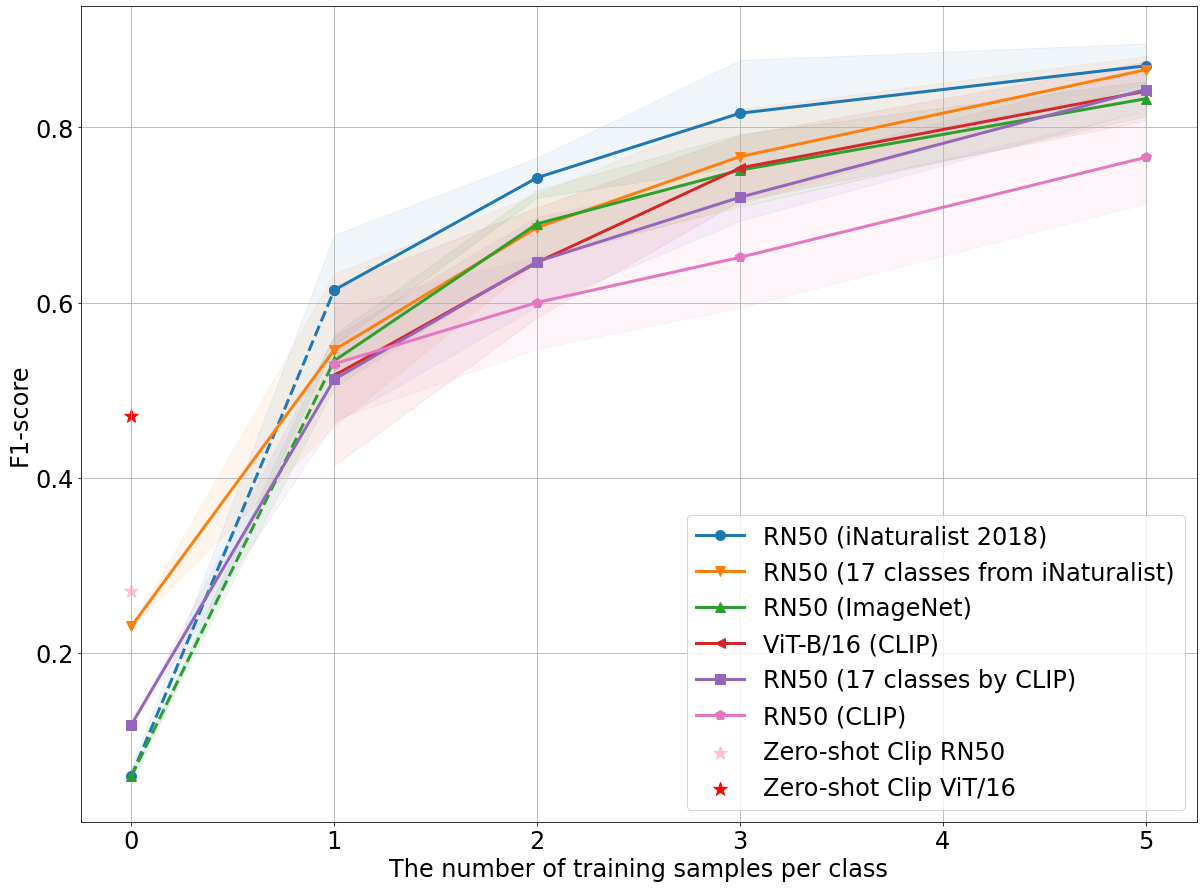

In [79]:
matplotlib.rcParams.update({'font.size': 24})
results_full.loc[(results_full['stage'].isin(['no_pretrain', 'check_full_pretrain'])) & (results_full['k'] == 0), 'mean_f1_score'] = 1 / 17
fig = plt.figure(figsize=(20, 15))
stages = ['check_full_pretrain', 'check_part_pretrain_inaturalist', 'no_pretrain',  
          'check_clip_ViT-B/16', 'check_part_pretrain_clip', 'check_clip_RN50']

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:pink']

labels = {'check_full_pretrain': 'RN50 (iNaturalist 2018)', 'check_part_pretrain_inaturalist': 'RN50 (17 classes from iNaturalist)',
          'no_pretrain': 'RN50 (ImageNet)',  'check_clip_ViT-B/16': 'ViT-B/16 (CLIP)', 
          'check_part_pretrain_clip': 'RN50 (17 classes by CLIP)',
          'check_clip_RN50': 'RN50 (CLIP)'}
markers = ['o', 'v', '^', '<', 's', 'p']
for i, (stage, color) in enumerate(zip(stages, colors)):
    if 'part' in stage:
        linestyle = '-'
    else:
        linestyle = '--'
    results = results_full[results_full['stage'] == stage]
    results = results[results['k'] != 4]
    results = results[results['k'] != 8]
    plt.plot(results[results['k'] < 2]['k'], results[results['k'] < 2][f'mean_{metric}'], color=color, linestyle=linestyle, linewidth=3, marker=markers[i], ms=10)
    plt.plot(results[results['k'] > 0]['k'], results[results['k'] > 0][f'mean_{metric}'], color=color, label=f'{labels[stage]}', linewidth=3, marker=markers[i], ms=10)
    plt.fill_between(results['k'], (results[f'mean_{metric}'] - results[f'std_{metric}']),
                     (results[f'mean_{metric}'] + results[f'std_{metric}']), color = color, alpha=0.07)
#     plt.title(f'Mean {metric}')
colors = ['pink', 'red']
labels = ['Zero-shot Clip RN50', 'Zero-shot Clip ViT/16']
zero_shot_f1_scores = {'Zero-shot Clip RN50': 0.27, 'Zero-shot Clip ViT/16': 0.47}
for label, color in zip(labels, colors):
    plt.scatter(0, zero_shot_f1_scores[label], color=color, label=label, marker='*', s=200)
plt.xlabel('The number of training samples per class')
plt.ylabel('F1-score')
plt.grid()
plt.legend()
# tracker.add_figure(f'{metric.upper()}', fig)
# tracker.flush()
plt.show()

In [52]:
df = pd.read_csv('../splits/test_k0_#0')
df.shape

(228, 2)

In [57]:
import PIL
import numpy as np
img = PIL.Image.open('../data/classification_17_clean/0/0.jpeg')
np.array(img).shape

(1000, 1000, 3)